In [47]:
# Step 1.0 - Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_curve, auc)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [48]:
import warnings
warnings.filterwarnings("ignore")

- Loading the dataset

In [49]:
data = pd.read_csv("RTA Dataset.csv")
data.head()

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


- Viewing the columns contained in my dataset

In [ ]:
print("\nCOLUMN NAMES:")
data.columns


COLUMN NAMES:


Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

- Shaping my datset in column row format

In [8]:
data.shape

(12316, 32)

- Checking for mising values

In [11]:
data.isnull().sum()

Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                308
Casualty_class                    0
Sex_of_casualty                   0
Age_band_of_casualty              0
Casualty_severity                 0
Work_of_casuality           

- Checking the target variable's distribution

- Dealing with missing values

In [ ]:
# drop columns with >50% missing
th = 0.5
cols_keep = data.columns[data.isnull().mean() < th]
data = data[cols_keep]

# fill categorical misses with "Unknown"
for c in data.select_dtypes(include='object').columns:
    data[c] = data[c].fillna("Unknown")

# if Time exists, extract hour
if "Time" in data.columns:
    try:
        data["Hour"] = pd.to_datetime(data["Time"], errors='coerce').dt.hour
        data["Hour"].fillna(data["Hour"].median(), inplace=True)
    except:
        pass

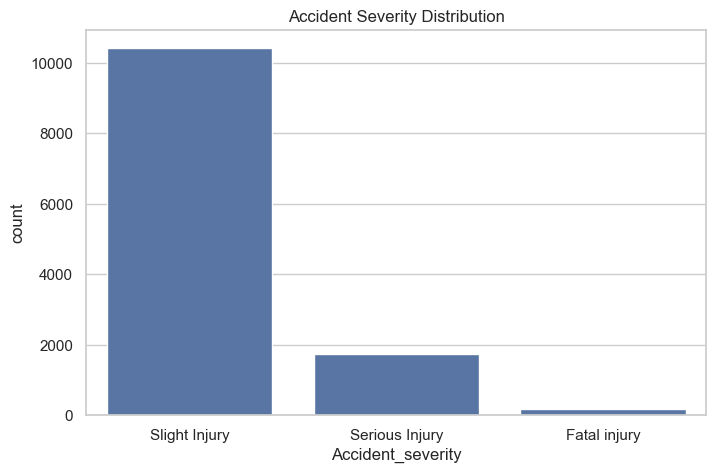

In [13]:
# Plot distribution
sns.countplot(x="Accident_severity", data=data)
plt.title("Accident Severity Distribution")
plt.show()

- Dropping the unecesary cloumns

- Many casuality fields apply only when injuries occur thus they cause noise and having too many missing values which we don't want to use in this process

In [ ]:
drop_columns = [
    'Work_of_casuality',
    'Fitness_of_casuality',
    'Sex_of_casuality',
    'Age_band_of_casualty',
    'Casualty_class',
    'Pedestrian_movement' 
]
for col in drop_columns:
    if col in data.columns:
        data = data.drop(col, axis=1)

print("Shape after dropping irrelevant columns:", data.shape)

Shape after dropping irrelevant columns: (12316, 27)


- Handling missing values

In [15]:
# Strategy:
# - Categorical features → replace NA with "Unknown"
# - Time → converted to hour

# Fill categorical missing values with "Unknown"
data = data.fillna("Unknown")

# Convert Time → hour of day
def extract_hour(x):
    try:
        return int(x.split(':')[0])
    except:
        return 0

data["Hour"] = data["Time"].apply(extract_hour)

# Drop the original time column
data = data.drop("Time", axis=1)

print("Missing values after cleaning:")
print(data.isna().sum().sum())  

Missing values after cleaning:
0


- Label encoding my target variable so that it can be identified  using numerical values

In [ ]:
label = LabelEncoder()
data["Accident_severity"] = label.fit_transform(data["Accident_severity"])

print("Encoding of target variable:")
print(dict(zip(label.classes_, label.transform(label.classes_))))

Encoding of target variable:
{'Fatal injury': 0, 'Serious Injury': 1, 'Slight Injury': 2}


- Using one-hot encoding for the categorical features

In [17]:
X = data.drop("Accident_severity", axis=1)
y = data["Accident_severity"]

# Convert all categorical columns to one-hot
X = pd.get_dummies(X, drop_first=True)
print("Final input shape:", X.shape)

Final input shape: (12316, 159)


- Splitting the dataset into training and testing data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (9852, 159)
Test set shape: (2464, 159)


- Scaling the features  to ensure features with different units/ranges contribute comparably, improving optimization speed/stability for gradient-based models.

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

- Building the neural network

In [21]:

# Architecture chosen for accuracy + stability
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 accident severity classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,915 (120.76 KB)

 Trainable params: 30,915 (120.76 KB)

 Non-trainable params: 0 (0.00 B)

- Traiing the model

In [35]:
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9684 - loss: 0.0830 - val_accuracy: 0.8097 - val_loss: 1.1495
Epoch 2/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9735 - loss: 0.0711 - val_accuracy: 0.8082 - val_loss: 1.1972
Epoch 3/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9754 - loss: 0.0691 - val_accuracy: 0.8108 - val_loss: 1.2678
Epoch 4/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9769 - loss: 0.0681 - val_accuracy: 0.8062 - val_loss: 1.2232
Epoch 5/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9744 - loss: 0.0709 - val_accuracy: 0.8118 - val_loss: 1.2009
Epoch 6/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9796 - loss: 0.0592 - val_accuracy: 0.8052 - val_loss: 1.2753
Epoch 7/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9731 - loss: 0.0715 - val_accuracy: 0.8062 - val_loss: 1.2164
Epoch 8/25
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9784 - loss: 0.0615 - val_accuracy: 0.

- Model Evaluation

In [36]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8121 - loss: 1.3726
Test Accuracy: 0.8120941519737244


- Confusion matrix and a report

In [40]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.19      0.07      0.11       349
           2       0.85      0.95      0.90      2084

    accuracy                           0.81      2464
   macro avg       0.35      0.34      0.33      2464
weighted avg       0.75      0.81      0.77      2464


Confusion Matrix:
[[   0    3   28]
 [   0   26  323]
 [   3  106 1975]]


- Training curve plots for the model

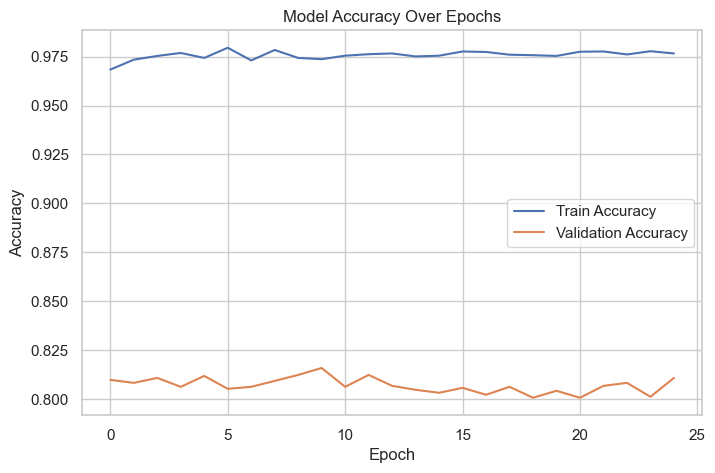

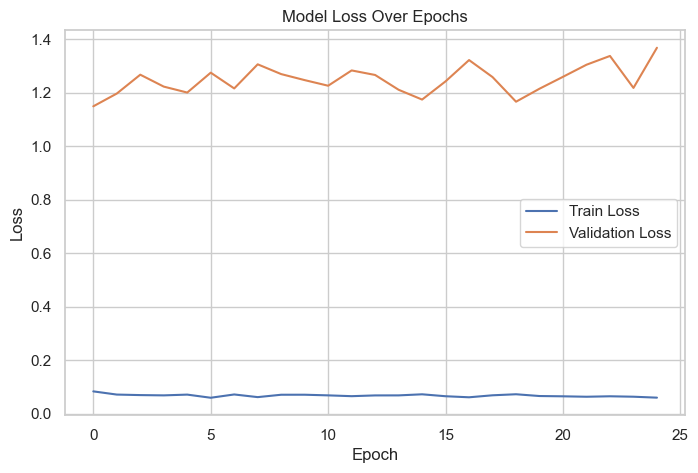

In [38]:
# Model Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Model Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


- Saving the model

In [ ]:
model.save("model1.h5")